# Contrastive PCA (cPCA)

In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
## Core packages
import warnings

warnings.filterwarnings("ignore")

# Numerical
import numpy as np
import pandas as pd

pd.set_option("display.max_columns", None)

# Plotting
import seaborn as sns

%matplotlib inline

sns.set_style("ticks")
%config InlineBackend.figure_format = 'retina'

## Single-cell packages for preprocessing and embedding

import scanpy as sc

sc.settings.verbosity = 1  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=150, fontsize=10, dpi_save=150, figsize=(5, 5), format="png")
sc.settings.figdir = "."

from contrastive import CPCA as CPCA_org

from scmetric.external import CPCA, CPCA_cov

### Synthetic Dataset

* There are 4 clusters in the target dataset (but we do not know their labels *a priori*. 
* In the background, all the data pts are from the same distribution, which has different variances in three subspaces.

In [3]:
from scipy.stats import ortho_group

np.random.seed(0)  # for reproducibility

# In A there are four clusters.
N = 400
D = 30
gap = 1.5
rotation = ortho_group.rvs(dim=D)

target = np.zeros((N, D))
target[:, 0:10] = np.random.normal(0, 10, (N, 10))
# group 1
target[0:100, 10:20] = np.random.normal(-gap, 1, (100, 10))
target[0:100, 20:30] = np.random.normal(-gap, 1, (100, 10))
# group 2
target[100:200, 10:20] = np.random.normal(-gap, 1, (100, 10))
target[100:200, 20:30] = np.random.normal(gap, 1, (100, 10))
# group 3
target[200:300, 10:20] = np.random.normal(2 * gap, 1, (100, 10))
target[200:300, 20:30] = np.random.normal(-gap, 1, (100, 10))
# group 4
target[300:400, 10:20] = np.random.normal(2 * gap, 1, (100, 10))
target[300:400, 20:30] = np.random.normal(gap, 1, (100, 10))
target = target.dot(rotation)
sub_group_labels = [0] * 100 + [1] * 100 + [2] * 100 + [3] * 100

background = np.zeros((N, D))
background[:, 0:10] = np.random.normal(0, 10, (N, 10))
background[:, 10:20] = np.random.normal(0, 3, (N, 10))
background[:, 20:30] = np.random.normal(0, 1, (N, 10))
background = background.dot(rotation)

data_ = np.concatenate((background, target))
labels_ = len(background) * [0] + len(target) * [1]

# Running the [original](https://github.com/abidlabs/contrastive) contrastive PCA implementation

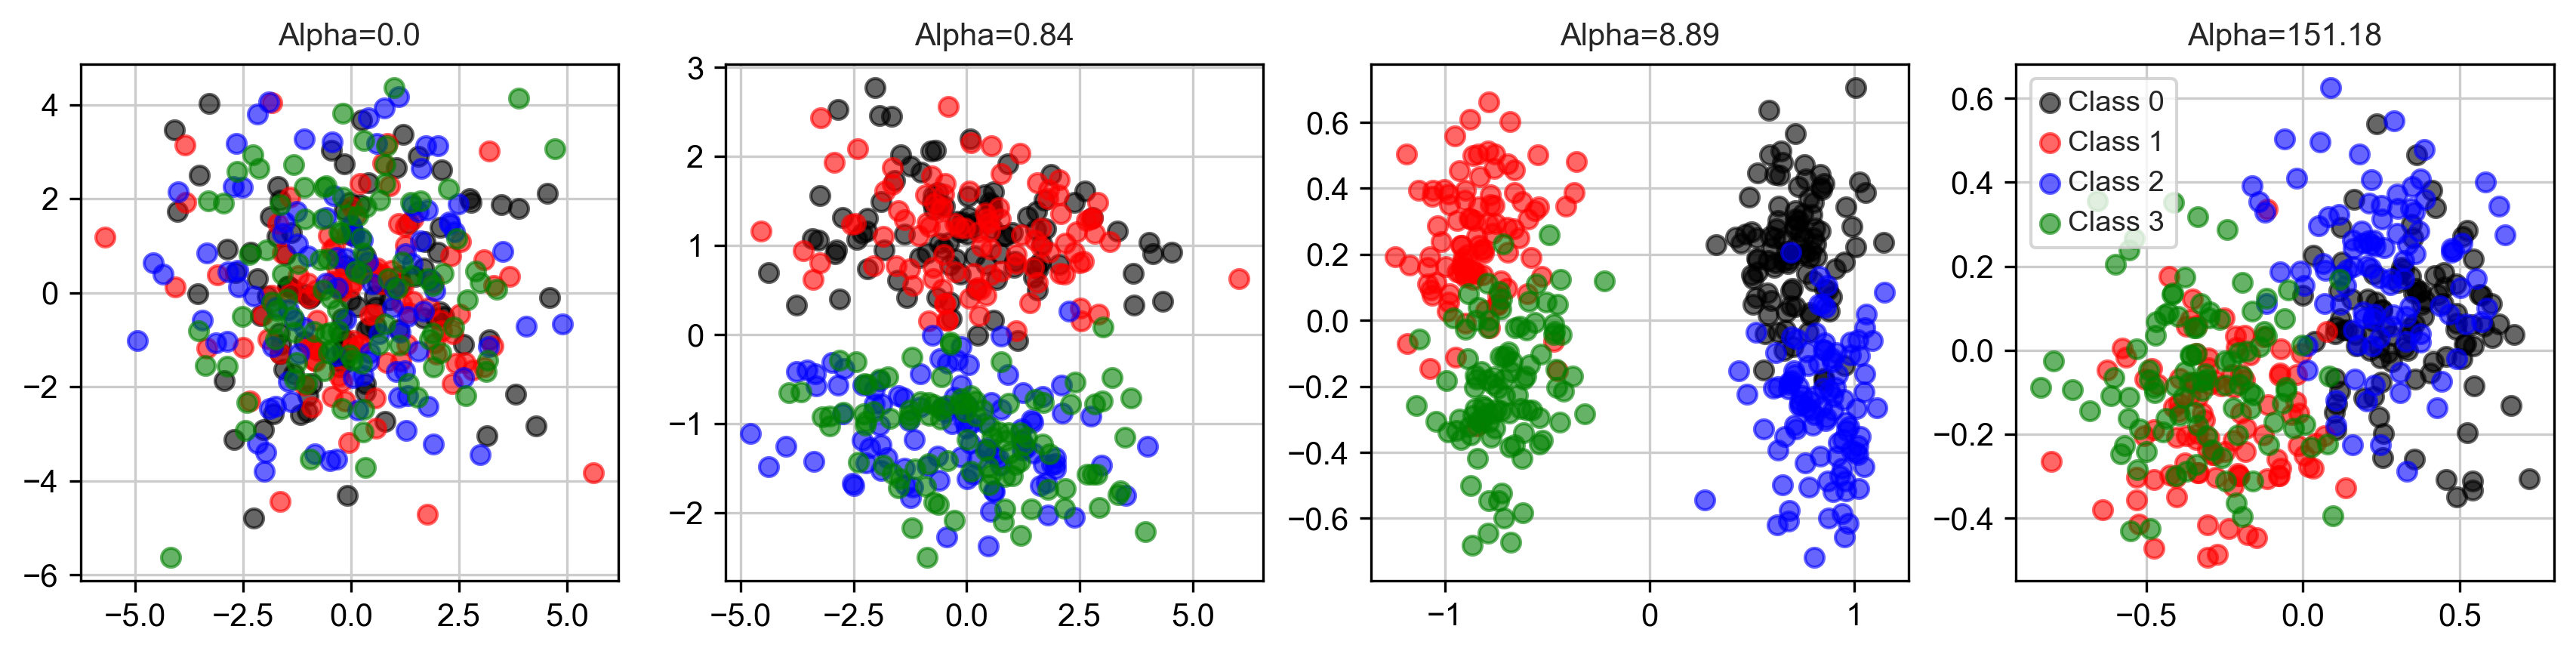

In [4]:
mdl = CPCA_org()

projected_data_ = mdl.fit_transform(target, background, plot=True, active_labels=sub_group_labels)

# Run the new version with adaptive alpha selection

iter 1: alpha=1.00e+00, target_var=3.00e+01, background_var=3.00e+01, contrastive_var=3.00e-05
iter 2: alpha=1.35e+00, target_var=1.81e+01, background_var=1.35e+01, contrastive_var=2.44e-05
iter 3: alpha=1.98e+00, target_var=6.40e+00, background_var=3.24e+00, contrastive_var=1.26e-05
iter 4: alpha=6.28e+00, target_var=2.11e+00, background_var=3.36e-01, contrastive_var=1.33e-05
iter 5: alpha=9.71e+00, target_var=1.20e+00, background_var=1.24e-01, contrastive_var=1.17e-05
iter 6: alpha=1.35e+01, target_var=6.99e-01, background_var=5.17e-02, contrastive_var=9.46e-06
iter 7: alpha=1.37e+01, target_var=6.72e-01, background_var=4.92e-02, contrastive_var=9.18e-06


<Figure size 600x4200 with 0 Axes>

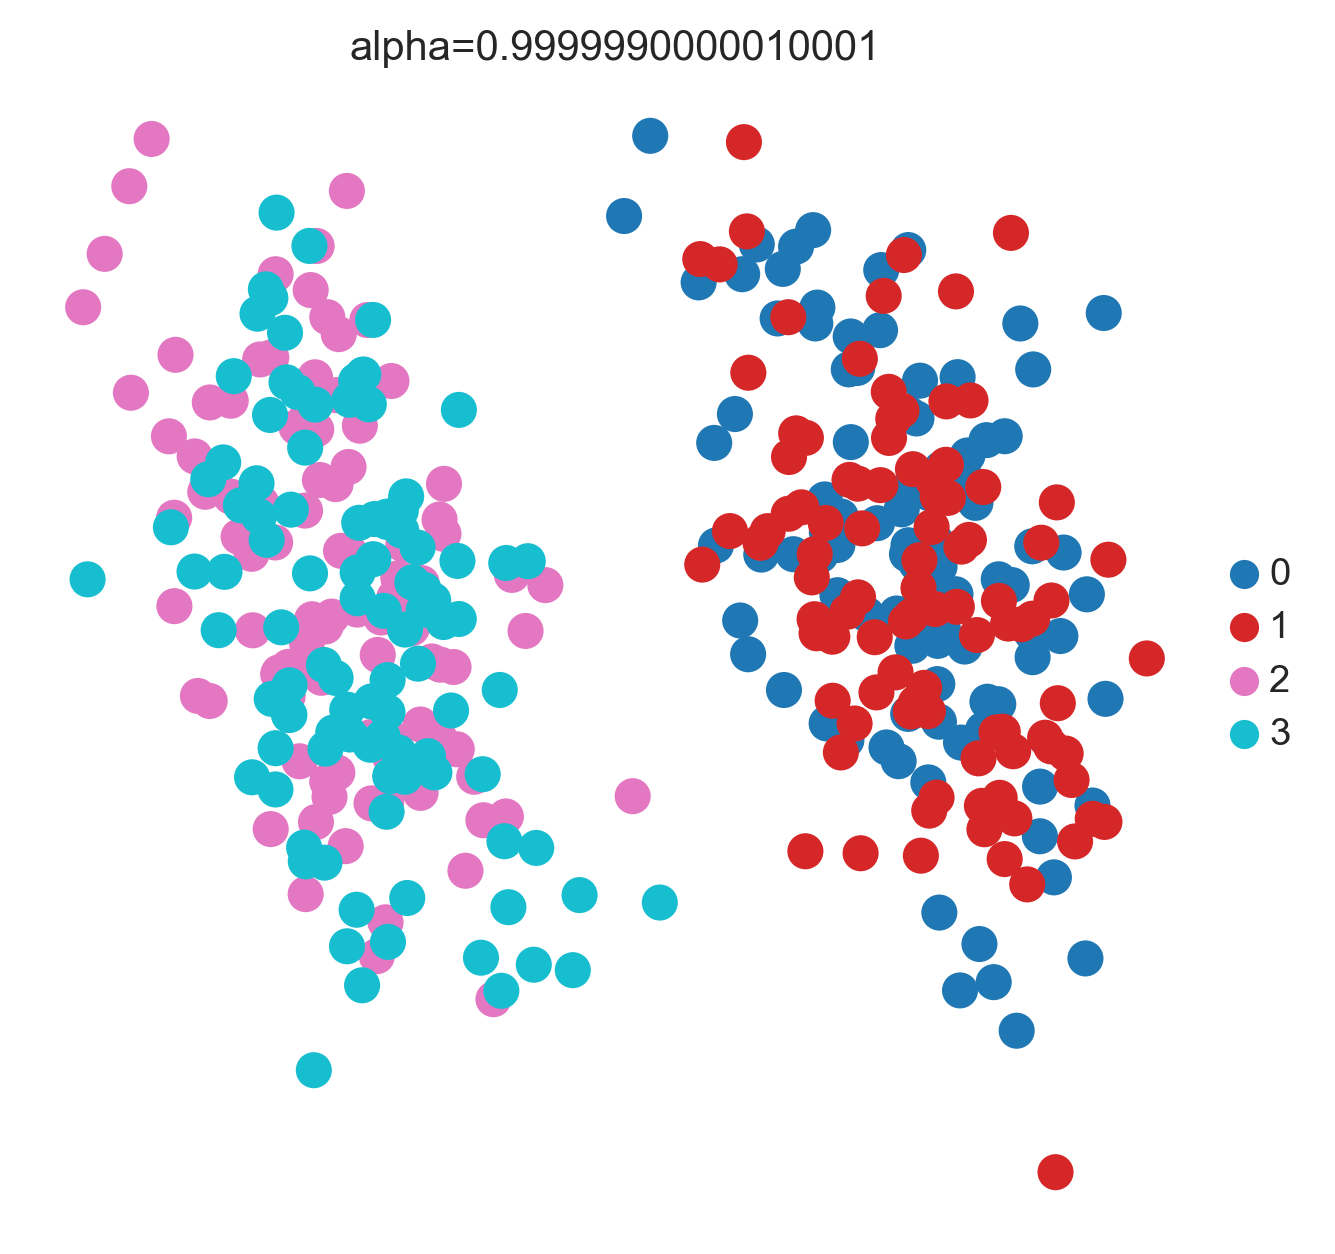

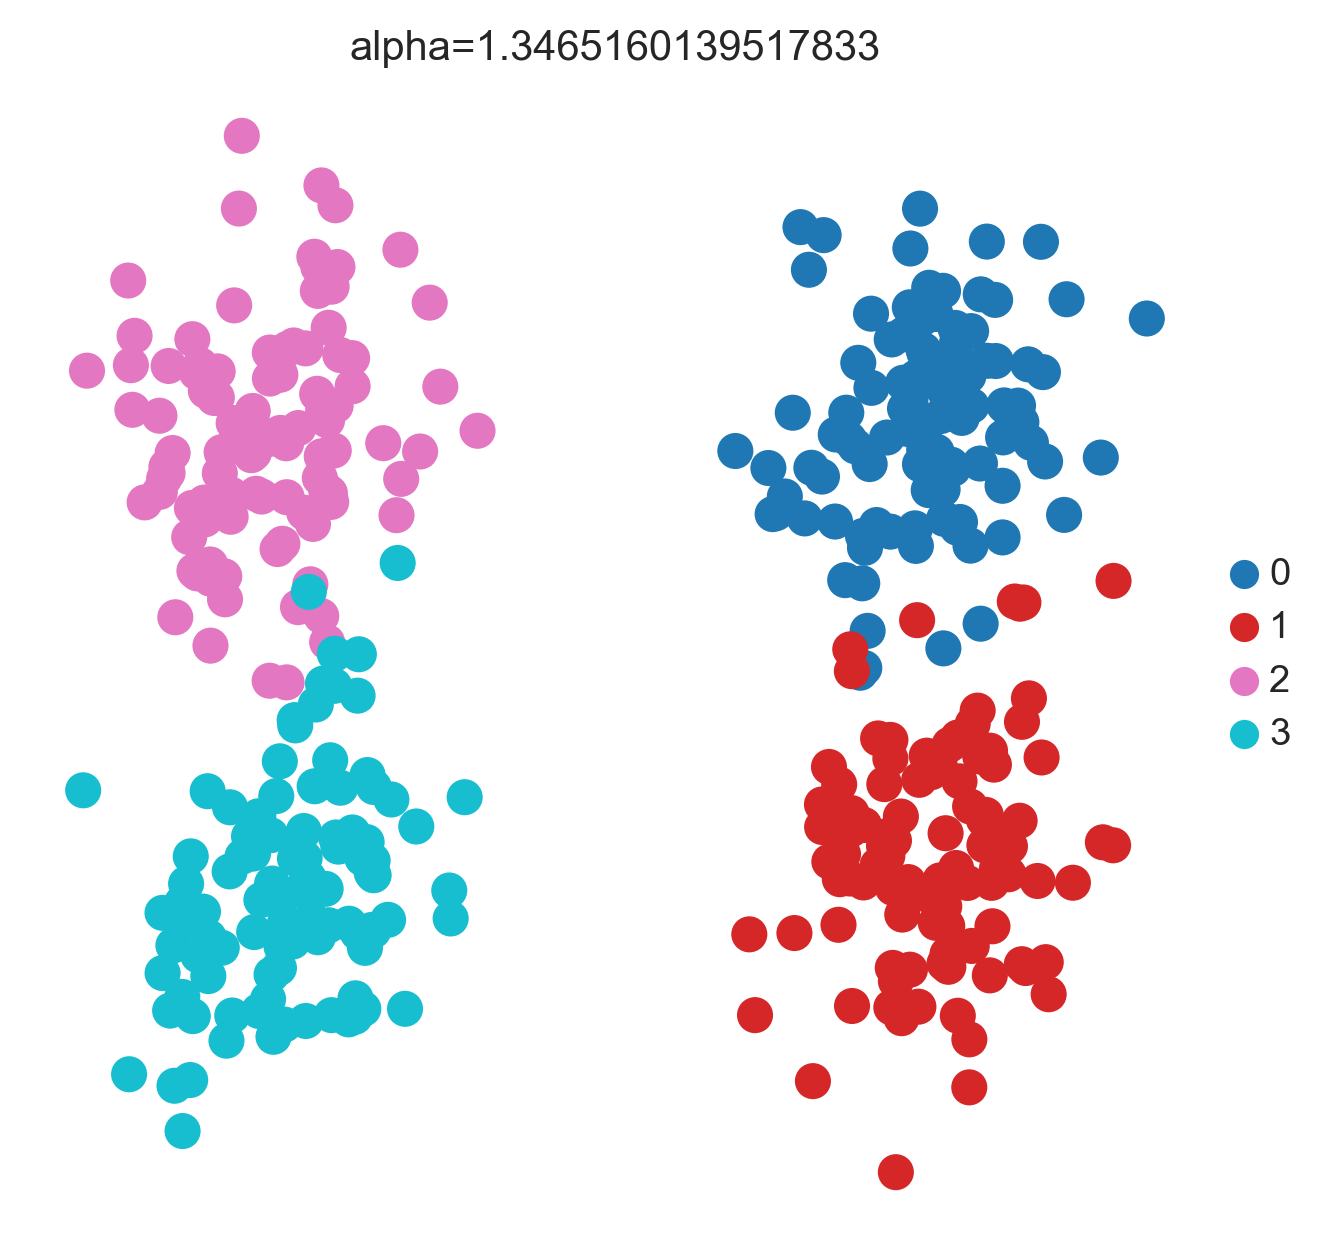

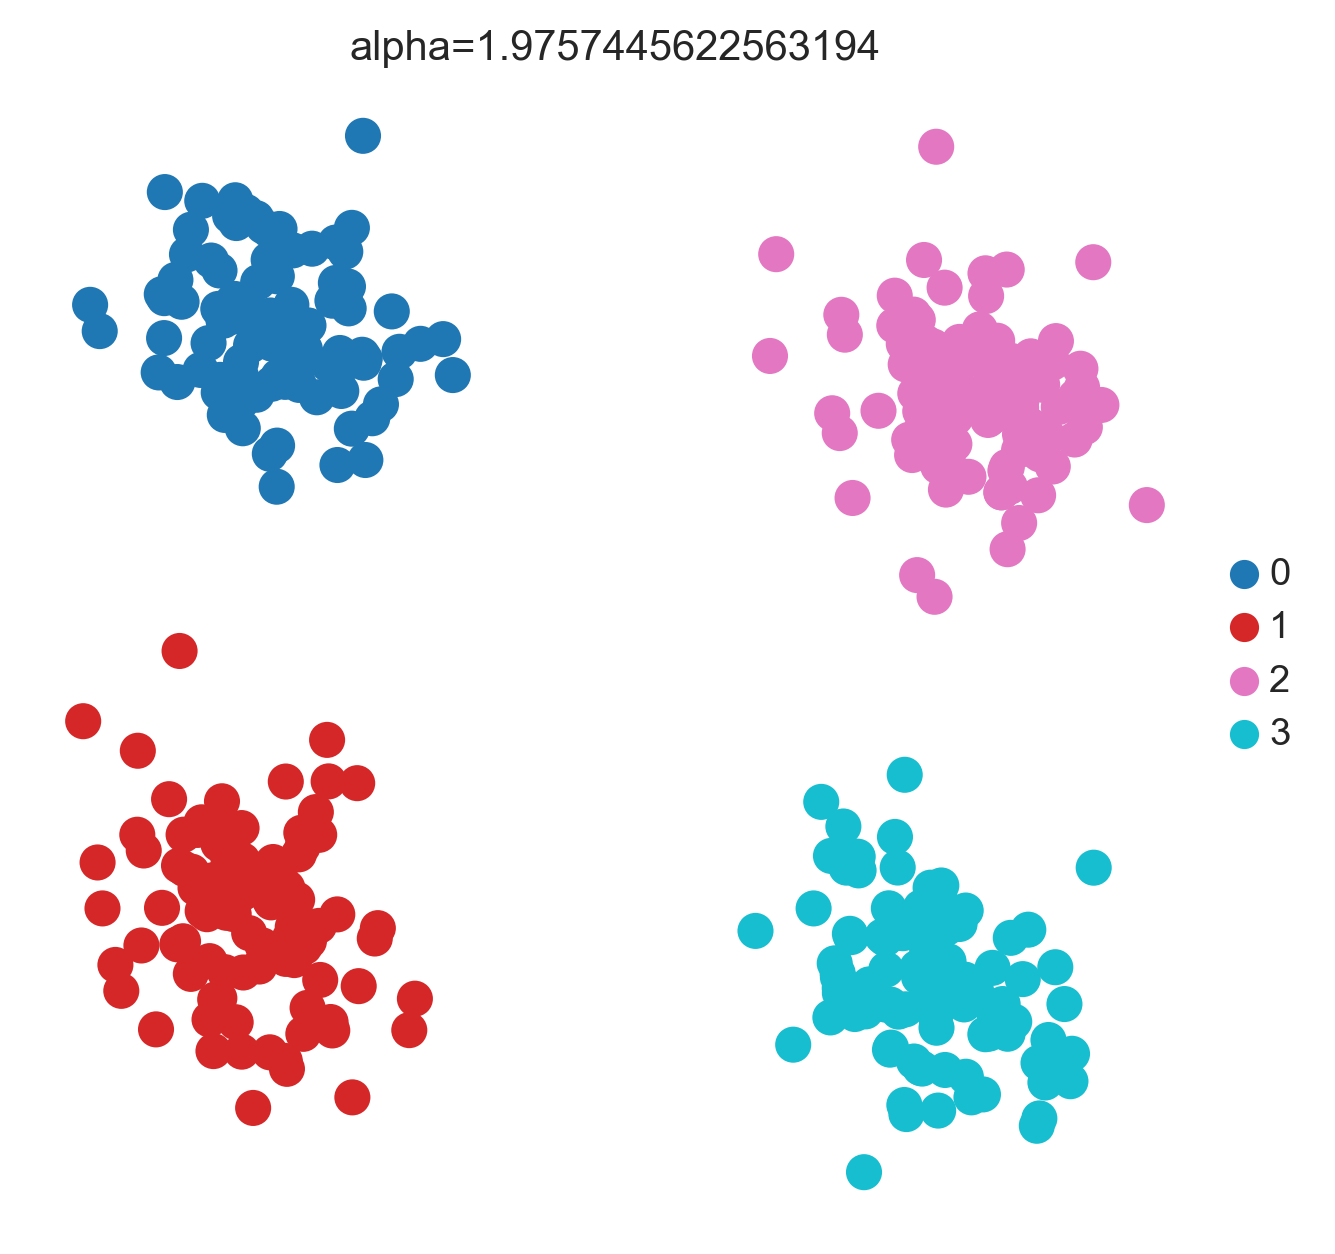

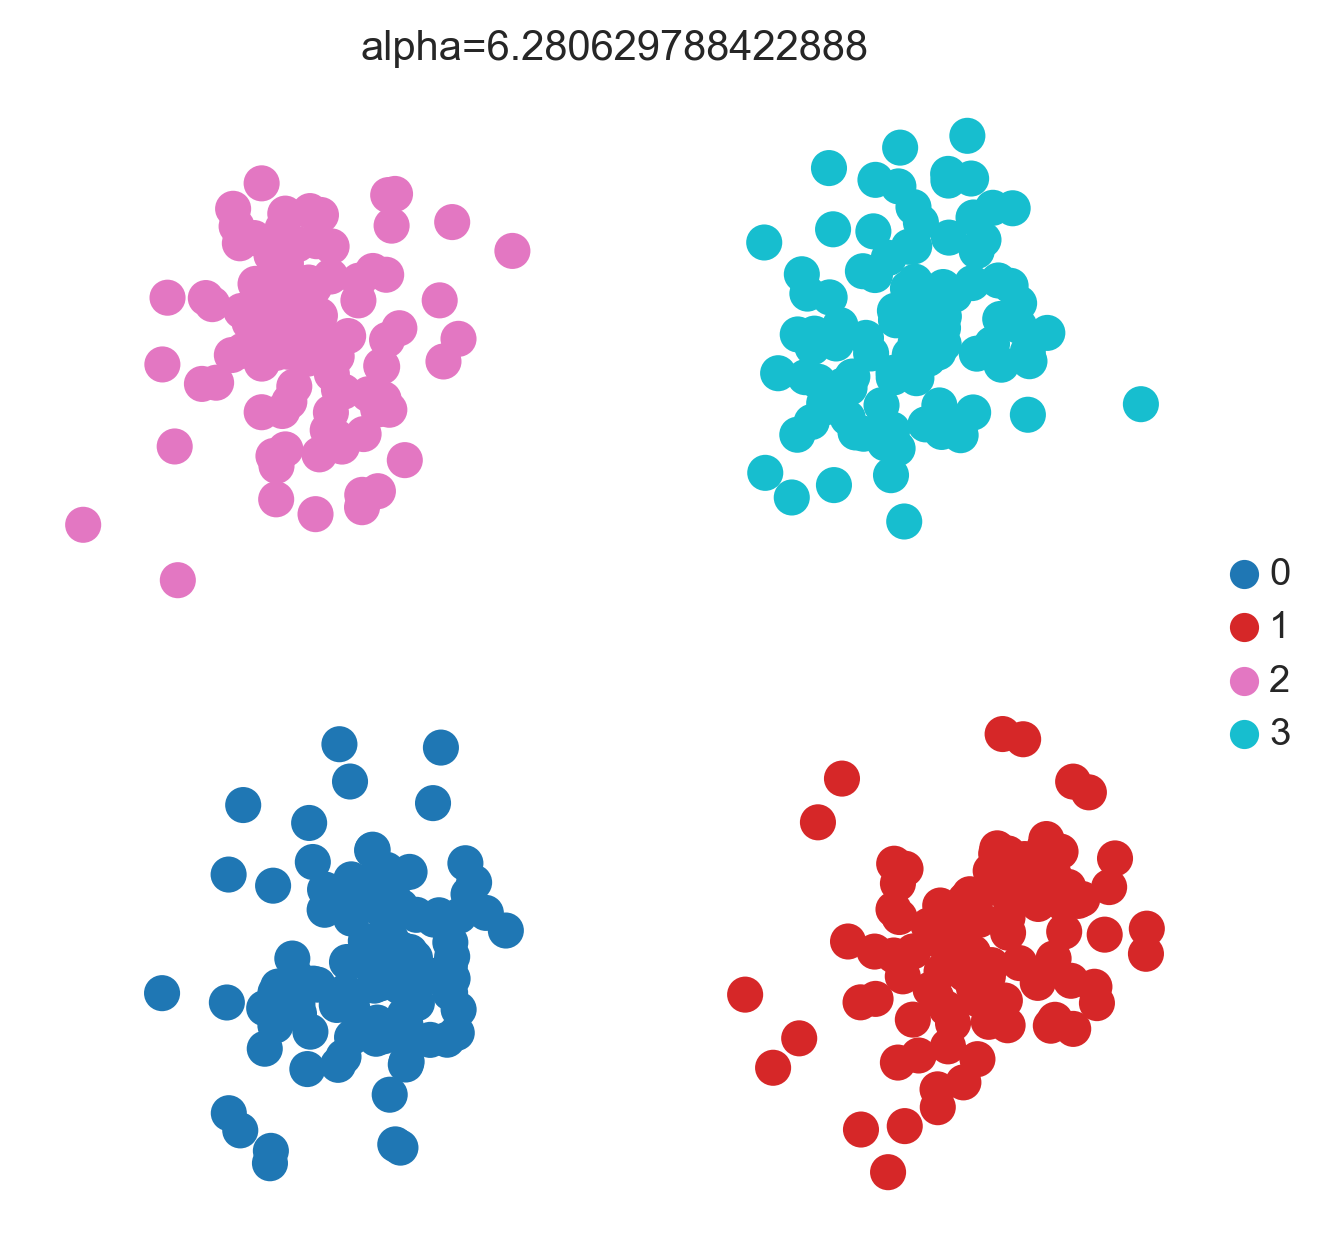

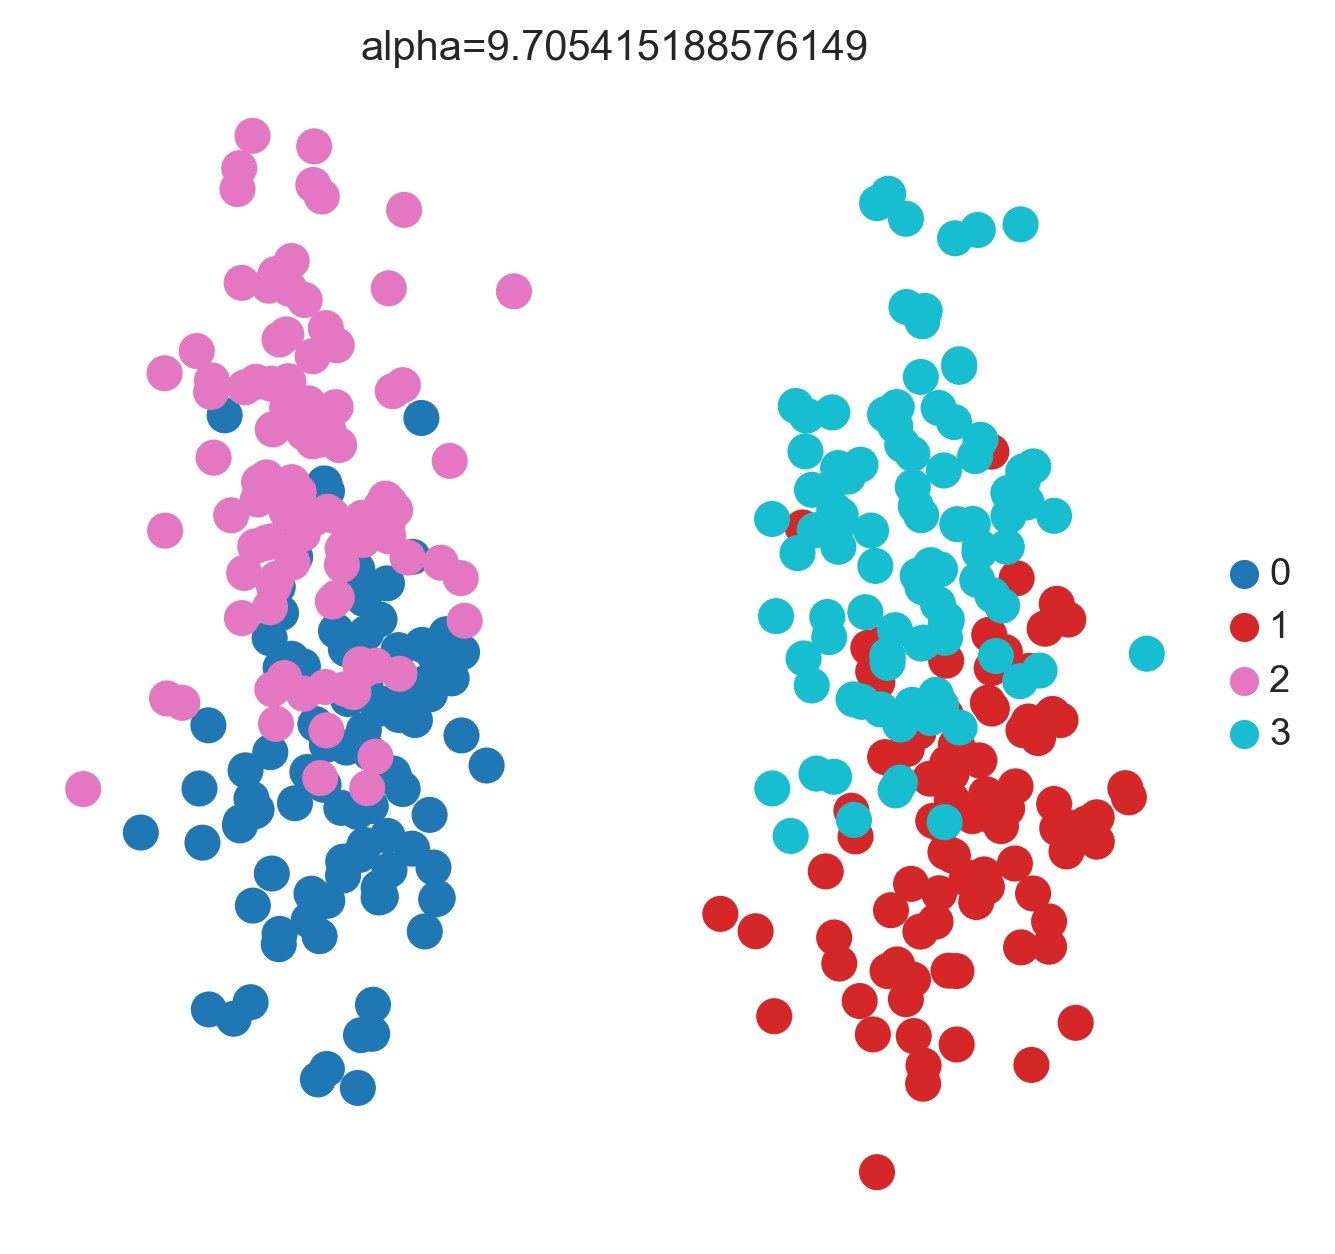

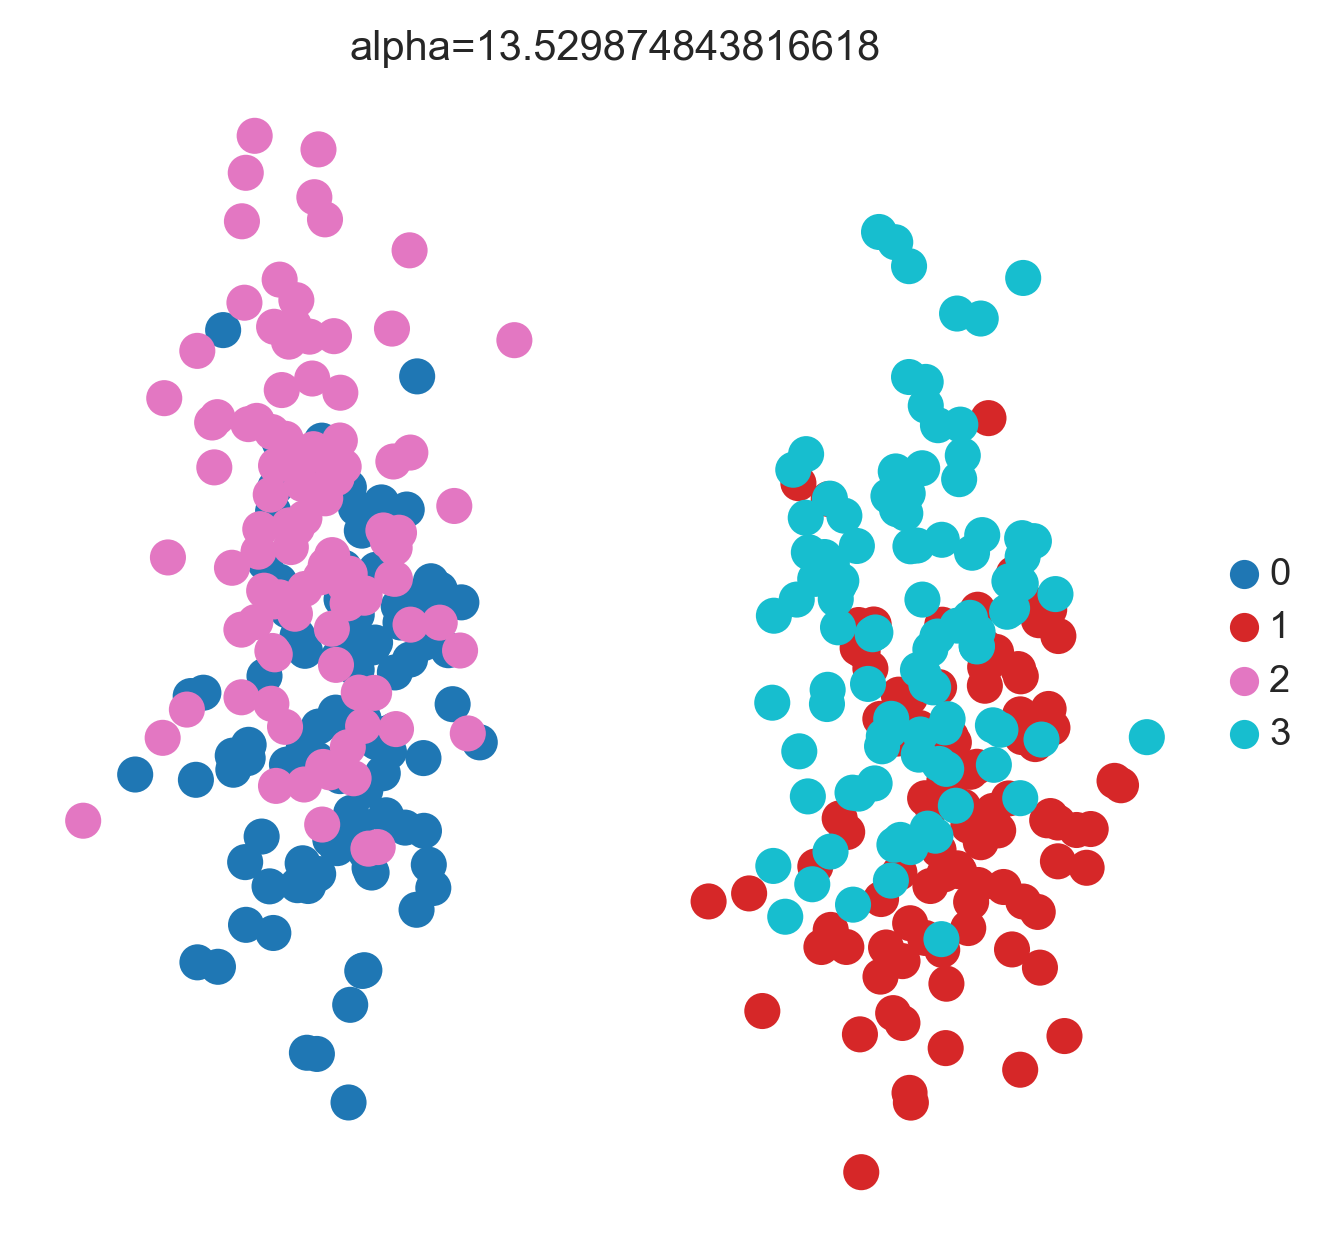

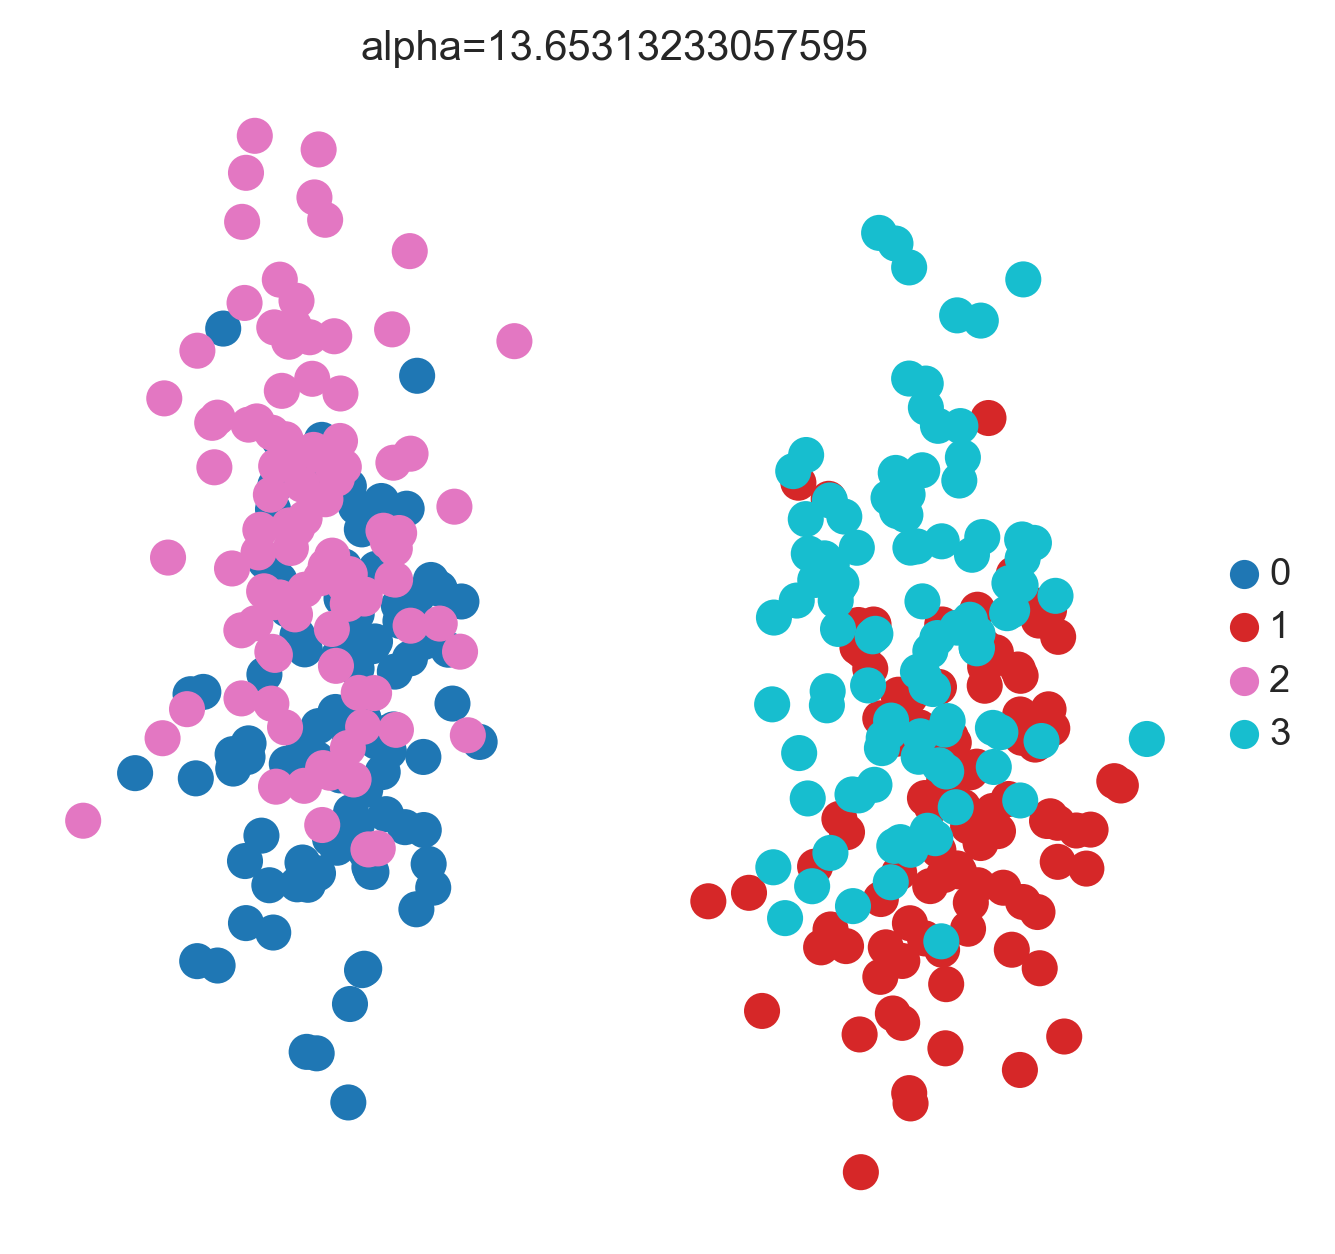

In [6]:
cpca_cov = CPCA_cov(n_components=2)
cpca_cov.fit(
    target_cov=np.corrcoef(target.T), background_cov=np.corrcoef(background.T), convergence_ratio=1e-3, eps=1e-6
)
cpca_cov.plot_projection_trace(target, sub_group_labels)

iter 1: alpha=1.00e+00, target_var=3.00e+01, background_var=3.00e+01, contrastive_var=3.00e-05
iter 2: alpha=1.35e+00, target_var=1.81e+01, background_var=1.35e+01, contrastive_var=2.44e-05
iter 3: alpha=1.98e+00, target_var=6.40e+00, background_var=3.24e+00, contrastive_var=1.26e-05
iter 4: alpha=6.28e+00, target_var=2.11e+00, background_var=3.36e-01, contrastive_var=1.33e-05
iter 5: alpha=9.71e+00, target_var=1.20e+00, background_var=1.24e-01, contrastive_var=1.17e-05
iter 6: alpha=1.35e+01, target_var=6.99e-01, background_var=5.17e-02, contrastive_var=9.46e-06
iter 7: alpha=1.37e+01, target_var=6.72e-01, background_var=4.92e-02, contrastive_var=9.18e-06


<Figure size 600x4200 with 0 Axes>

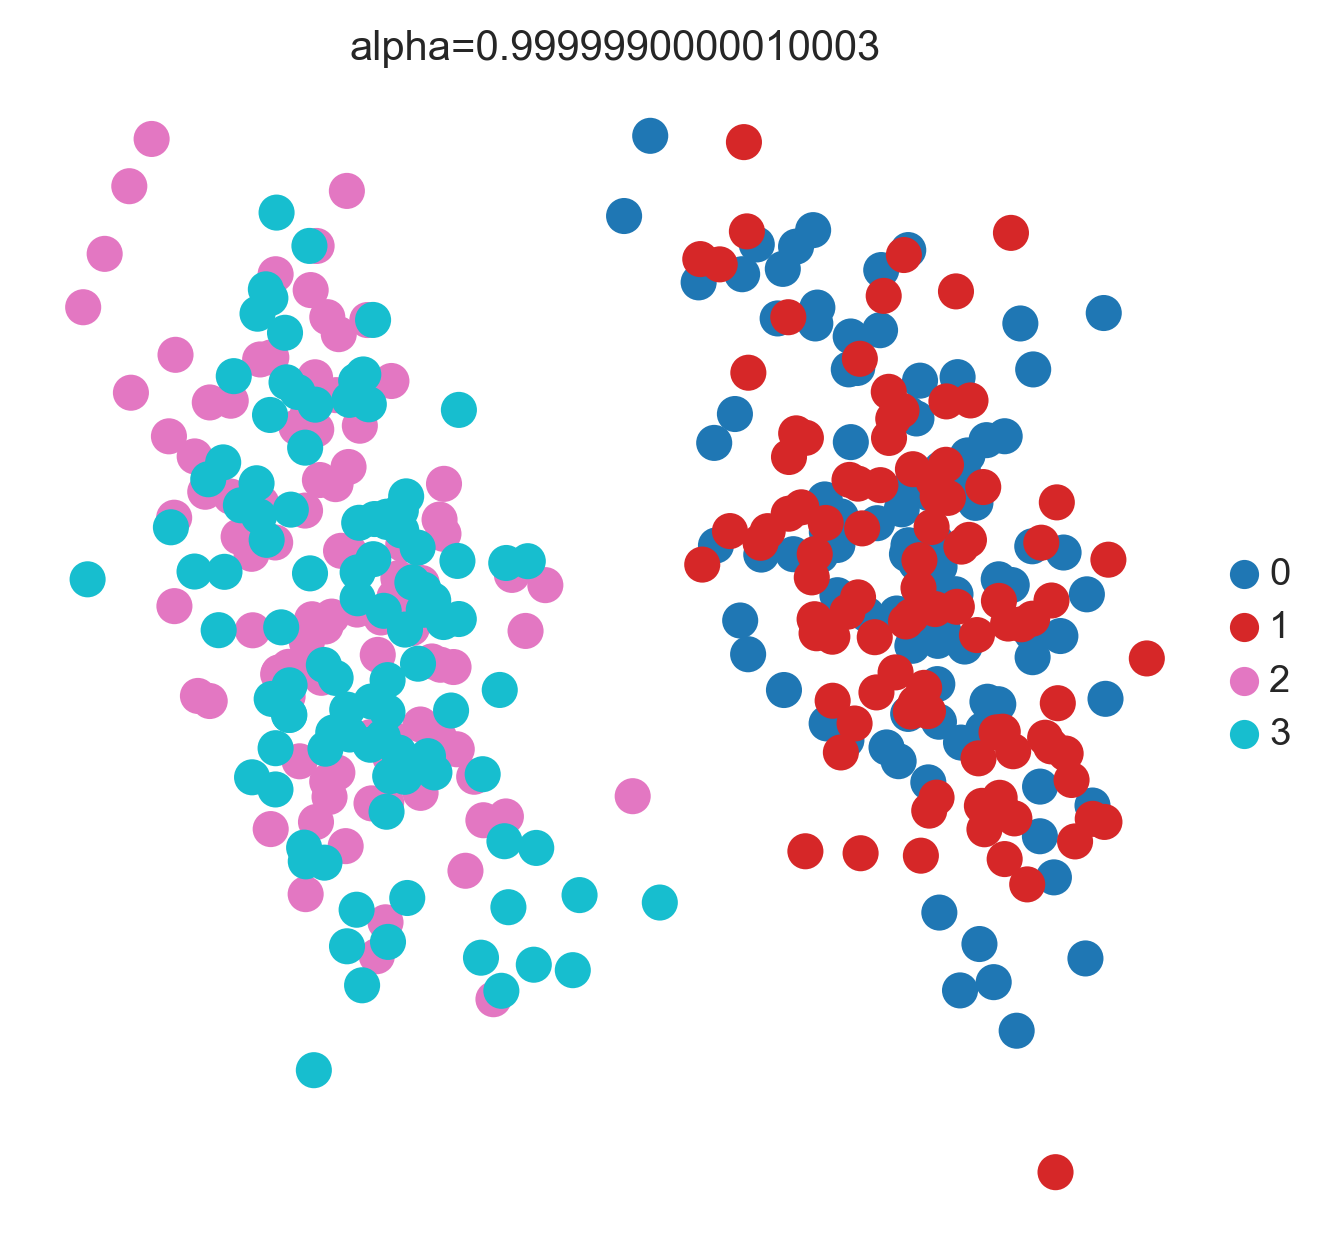

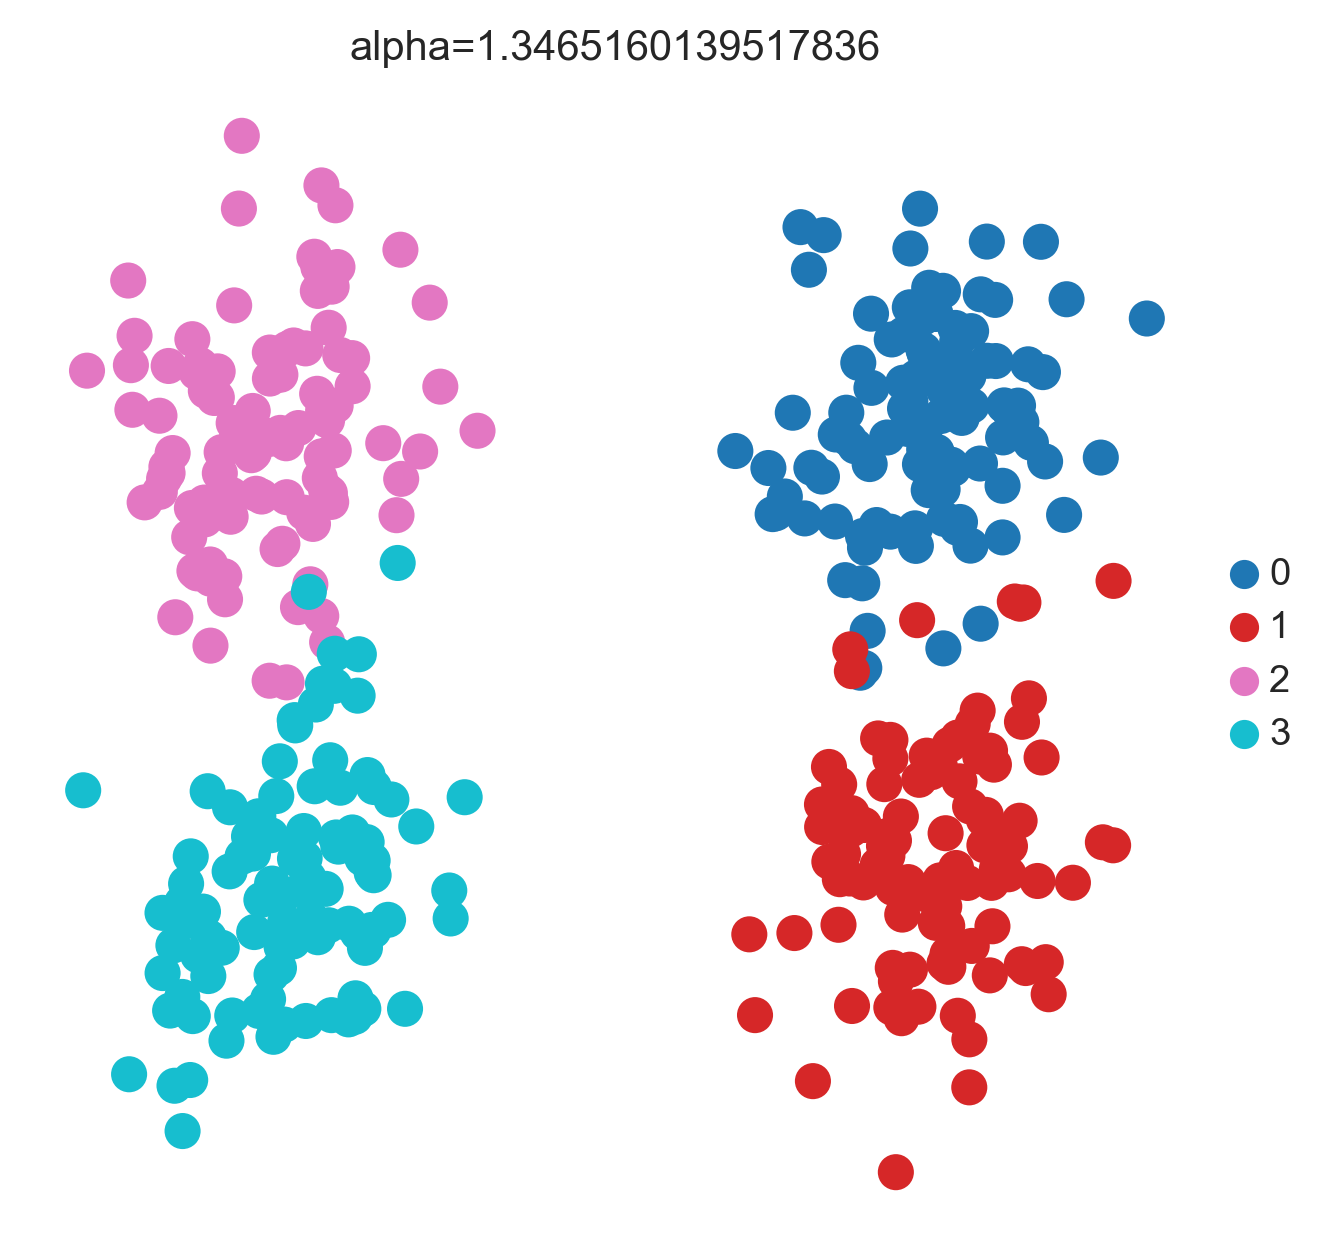

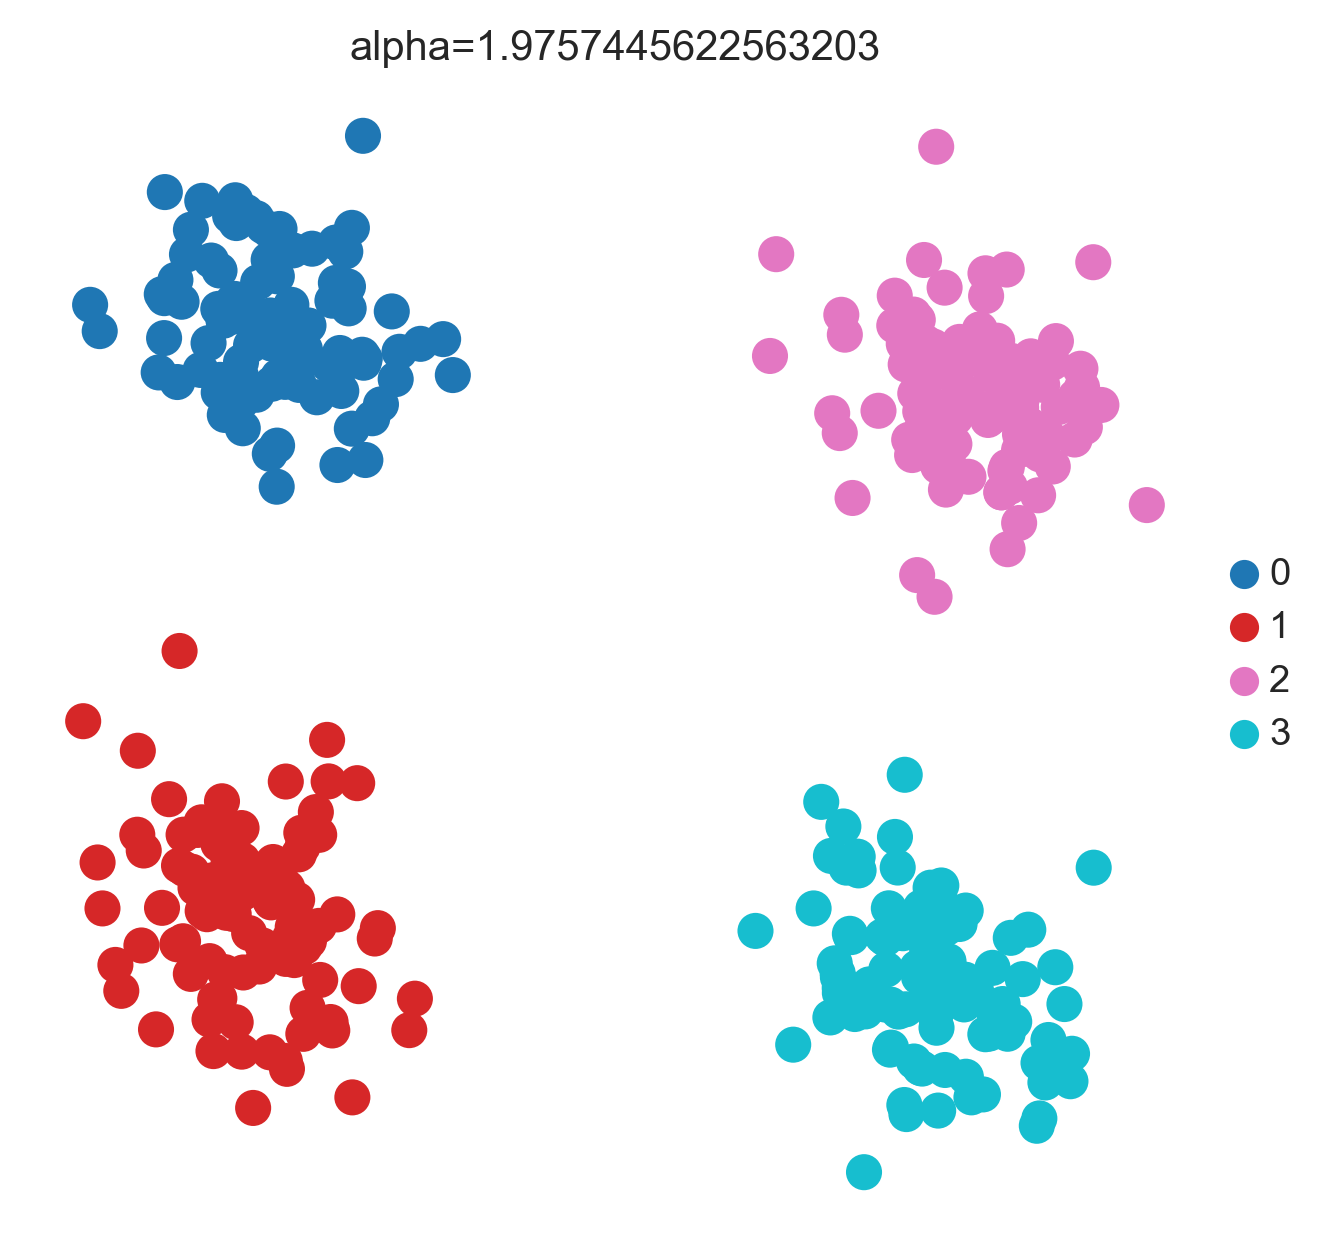

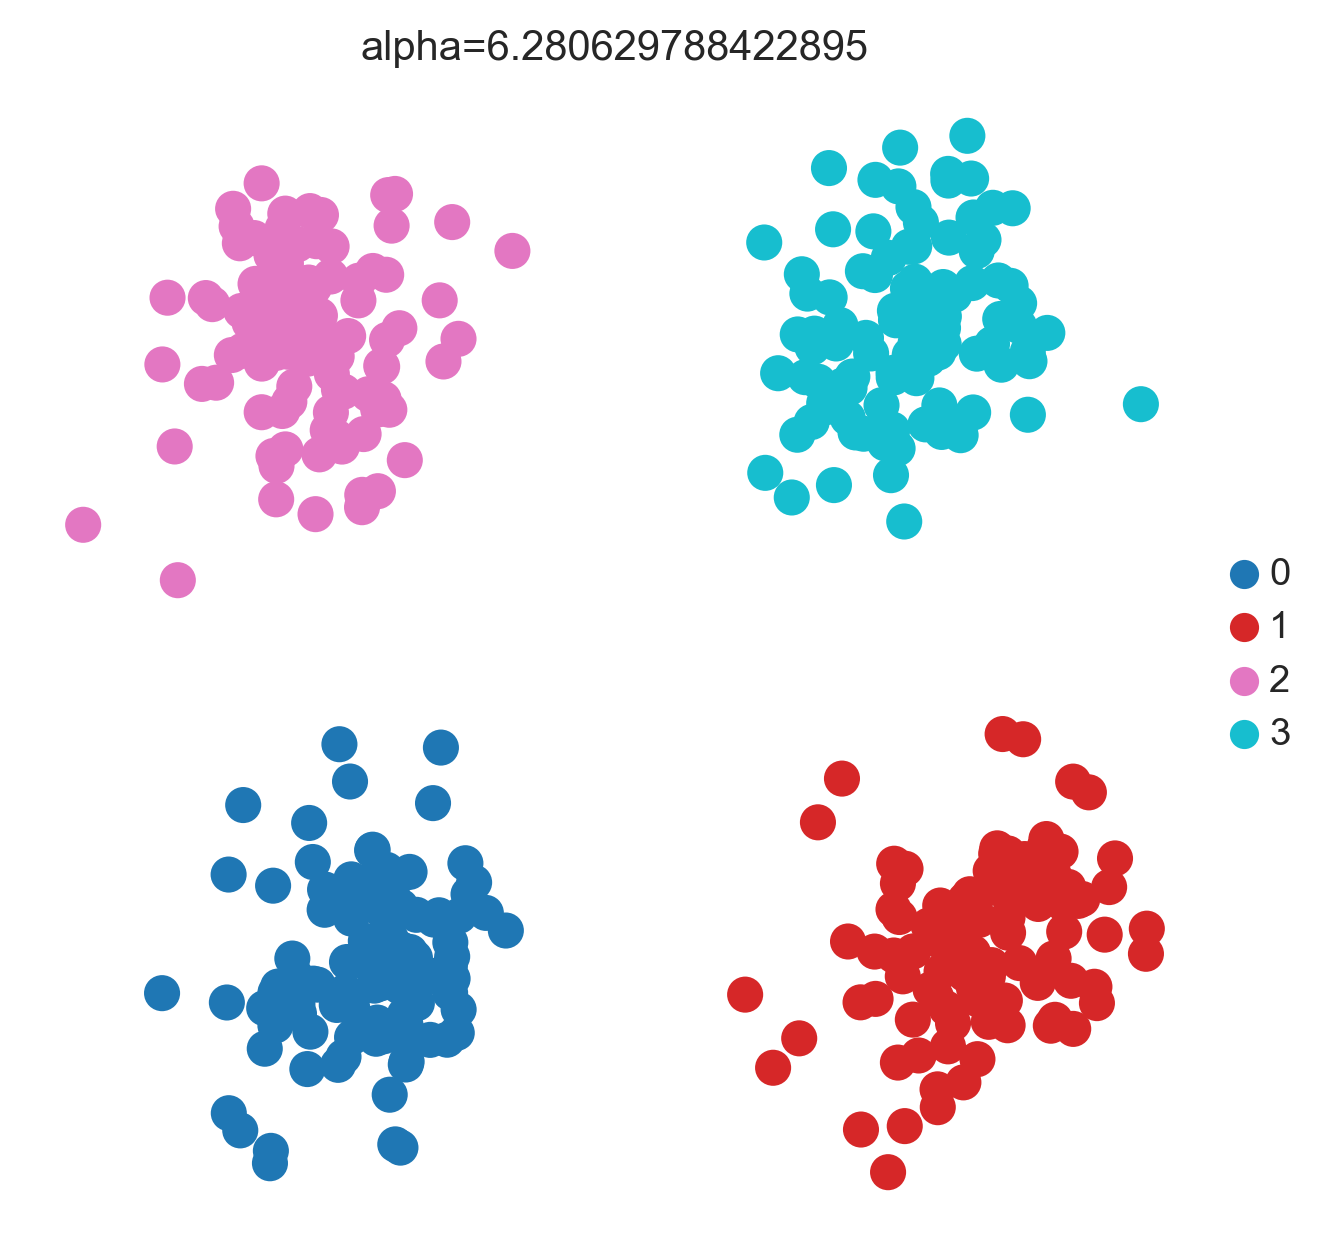

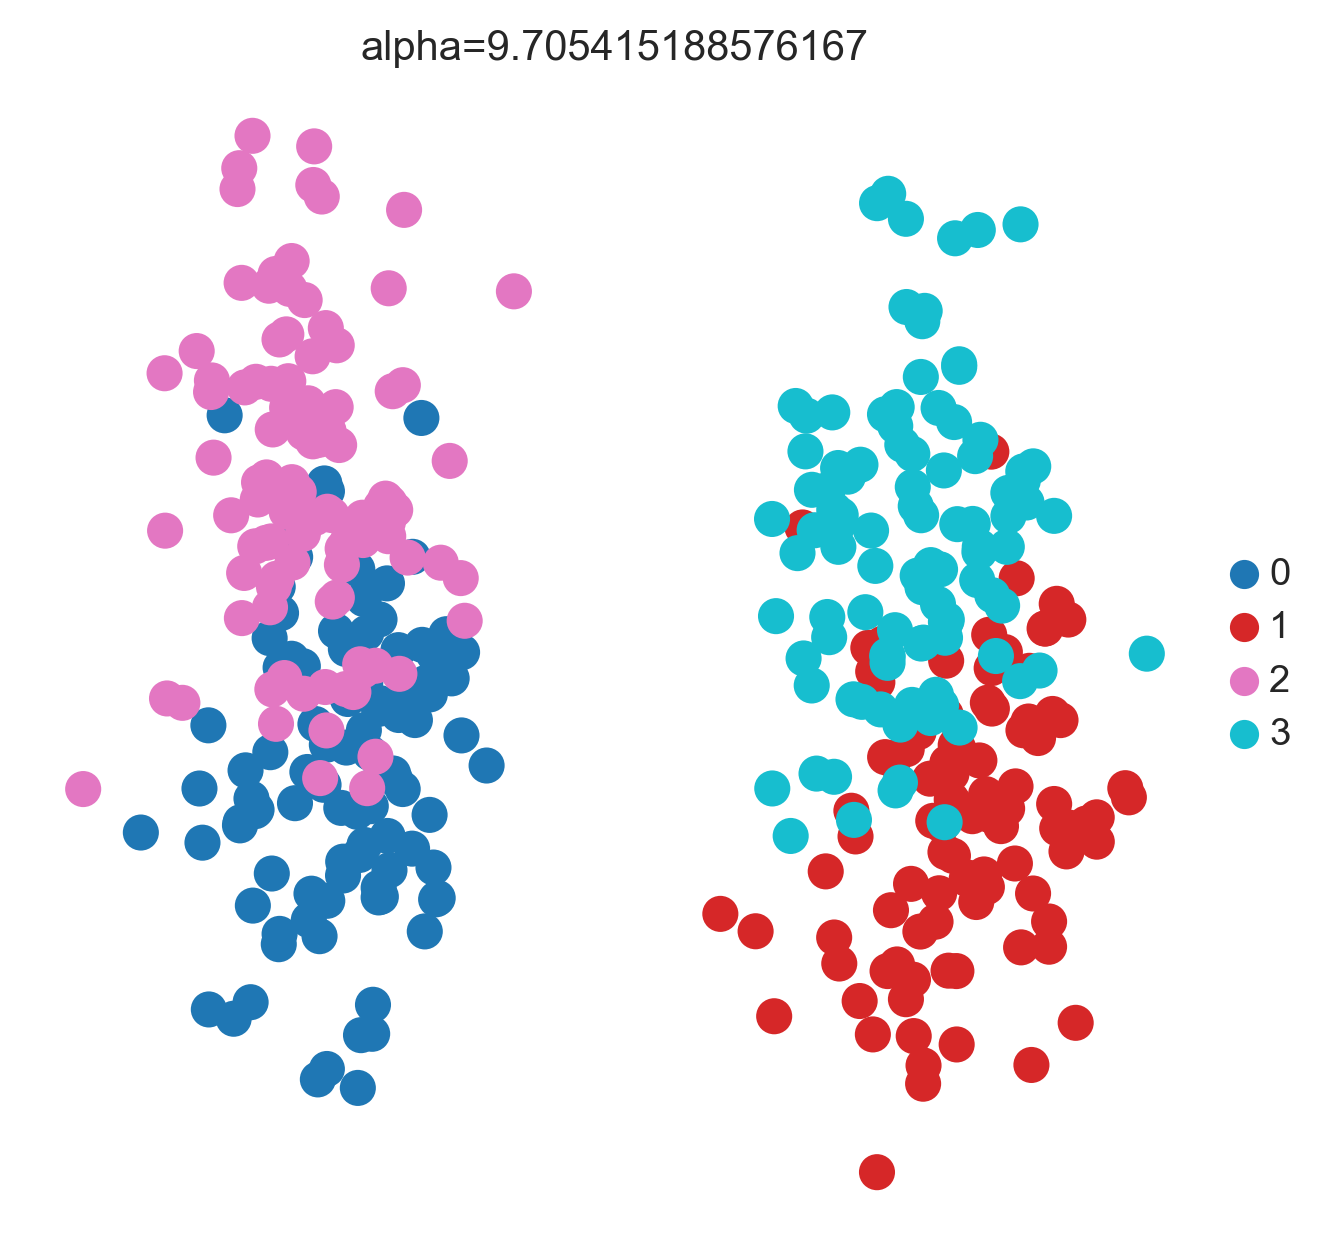

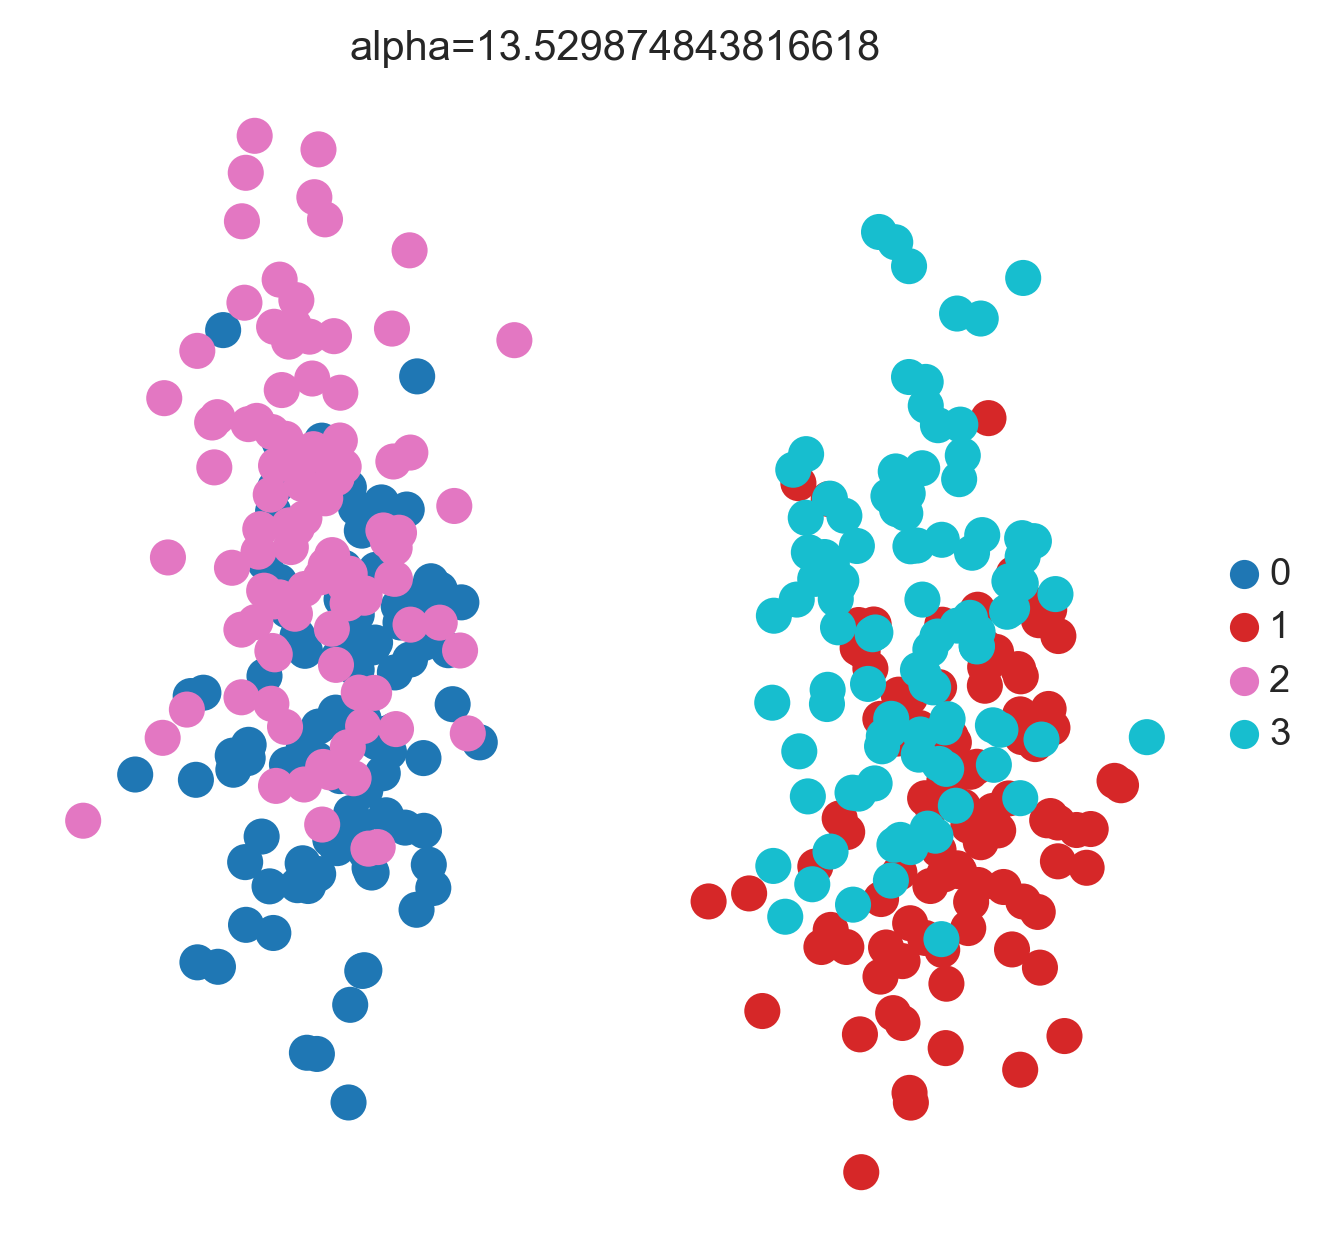

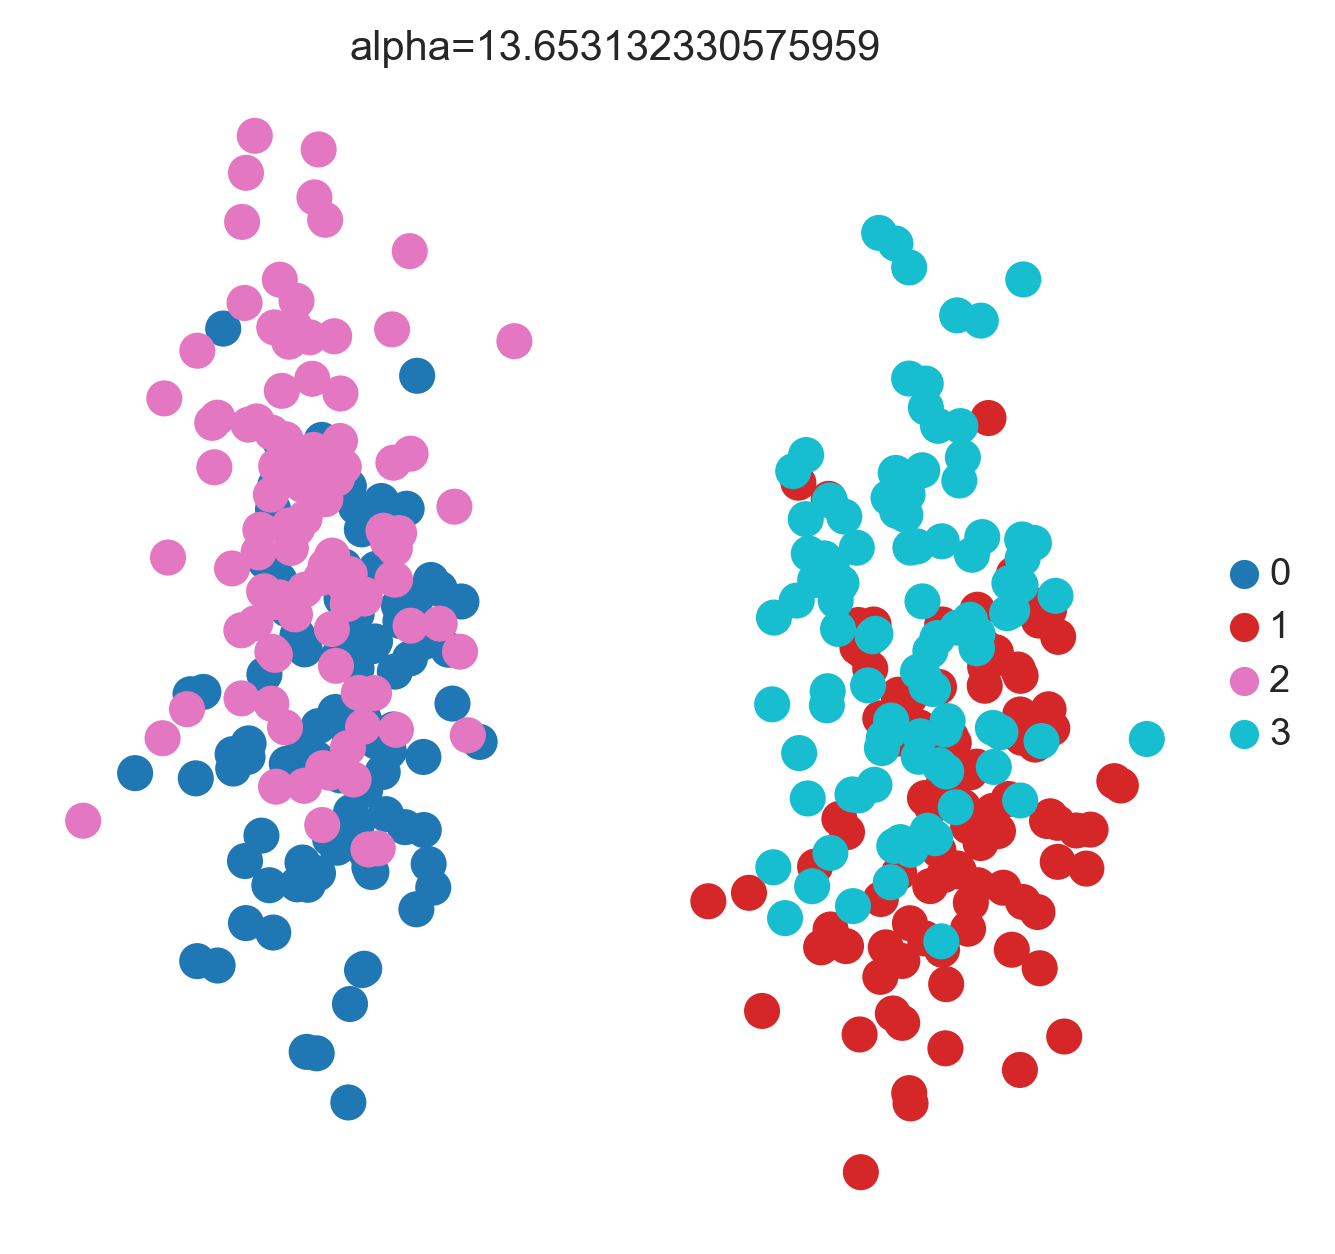

In [7]:
cpca = CPCA(n_components=2)
cpca.fit(target, background, convergence_ratio=1e-3, eps=1e-6)
cpca.plot_projection_trace(target, sub_group_labels)